# Random Forest Classification

In [2]:
# basic imports
import sys
sys.path.append('../scripts/')

import numpy as np
import matplotlib.pyplot as plt

# scikit-learn 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

# output 
import support_tools as st

In [5]:
import matplotlib
%matplotlib inline

## Load data:
Our example is a sample of central galaxies in SDSS with $\log(M_\ast) > 9.$ <br> <br>

The data structure is an array with shape (14133, 6), where the 6 columns are: <br>
- 0 $\log({\rm sSFR})$
- 1 target: whether a galaxy is passive (0) or star forming (1), based on $\log({\rm sSFR}) = -11$ threshold
- 2 random number in $[0,1)$
- 3 $\log(M_{\rm BH})$: BH mass
- 4 $\log(M_{\rm halo})$: halo mass
- 5 $\log(M_\ast)$: stellar mass

<br>
The sample consists of 153 550 passive objects and  74 477 star forming galaxies

In [6]:
data = np.genfromtxt('../DATA/SDSS-centrals-rf-data.txt')

### Quick look at the data

In [7]:
st.configure_plots() # some standard formatting declared as a function in ../scripts/support_tools.py

(0.0, 1.0, 0.0, 1.0)

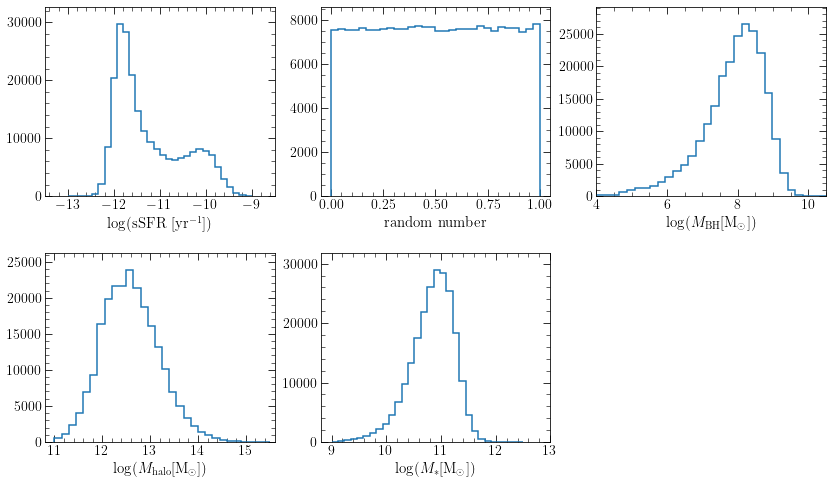

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(14,8))
fig.subplots_adjust(wspace=0.2, hspace=0.3)

labels = [
    r'$\log({\rm sSFR}\ [{\rm yr^{-1}}])$', 
    'random number',
    r'$\log(M_{\rm BH} [{\rm M_\odot}])$',
    r'$\log(M_{\rm halo} [{\rm M_\odot}])$',
    r'$\log(M_\ast [{\rm M_\odot}])$'
    ]

ranges = [
    (-13, -9), (0,1), (4,10.5),
    (11, 15.5), (9,12.5)
    ]

xlims = [
    (-13.5, -8.5), (-0.05, 1.05), (4, 10.5),
    (10.8, 15.6), (8.8, 13)
    ]

for i in range(5):
    a = ax.flatten()[i]
    if i != 0:
        n = a.hist(data[:,i+1], range=ranges[i], 
                   bins=30, histtype='step', linewidth=1.5)[0]
    else:
        n = a.hist(data[:,i], range=ranges[i], 
                   bins=30, histtype='step', linewidth=1.5)[0]
        
    a.set_ylim(0, n.max()*1.1)
    a.set_xlim(xlims[i])
    a.set_xlabel(labels[i])

ax.flatten()[5].axis('off')

***
## Prepare the training and validation sets

I.e. split the data into the set which the algorithm learns from and the 'unseen, new data' we test its performance on. <br>

#### Caveat:
As we can see from our data exploration, passive galaxy sample is twice as large as the star forming one. Hence, we choose to balance the sample by randomly subsampling the passive galaxy population to match the star forming population in size. This way, we prevent the algorithm from learning preferentially from the passive galaxy data and developing a bias towards it.

In [9]:
# construct a 'balanced sample' 
# note that we are no longer using sSFR from this moment on

data_pa = data[data[:,1]==1, 1:]    # passive 
data_sf = data[data[:,1]==0, 1:]    # star forming 

print('Passive population size: %d' %data_pa.shape[0])
print('Star forming population size: %d' %data_sf.shape[0])
   
subsample = np.random.choice(np.arange(data_pa.shape[0]),    # randomly sample the passive
                             size=data_sf.shape[0],          # population indices without
                             replace=False)                  # replacement

data_pa_sub = data_pa[subsample, :]
print('\nSubsampled passive population size: %d' %data_pa_sub.shape[0])

data_balanced = np.vstack((data_pa_sub, data_sf))
print('\nBalanced input sample size: %d' %data_balanced.shape[0])

Passive population size: 153550
Star forming population size: 74477

Subsampled passive population size: 74477

Balanced input sample size: 148954


#### Identify the target (known galaxy PA/SF classes) and the input features ($M_{\rm BH}$, $M_{\rm halo}$, $M_\ast$)

In [10]:
target = data_balanced[:,0].astype('int')    # note that the class labels are integers
features = data_balanced[:,1:]

RF requires all input features to be standardised in order for their individual dynamic ranges not to influence the algorithm learning. <br>

#### Hence, we then scale/normalise the input features using scikit-learn `RobustScaler`
![RobustScaler](support/robustscaler.png)
This module scales each feature in turn by removing the median and normalising all remaining data by the interquartile range specified by a user. This way one is not sensitive to outliers, in contrast with a mean + variance combination. Follow [this link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) for the scikit-learn manual <br>

In [11]:
scaler = preprocessing.RobustScaler(quantile_range=(5.0, 95.0),    # defaults to 25.0, 75.0
                                    copy=True)                     # one can set it to False for an inplace scaling
                                                                   # which has the potential to go wrong. Defaults
                                                                   # to True
        
scaled_features = scaler.fit_transform(features)    # fits the correct scaling for each feature and then applies
                                                    # it to the data

### Finally, we split the data into the training (tr) and validation (va) sets using `train_test_split`
![train_test_split](support/train-test-split.png)
Follow [this link](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) for the scikit-learn manual <br>

In [12]:
features_tr, features_va, target_tr, target_va = train_test_split(scaled_features,
                                                                  target,
                                                                  test_size=0.5)    # what fraction of the input
                                                                                    # input sample is dedicated
                                                                                    # to validation. Here, it is
                                                                                    # a 50/50 split

***
## Construct a RF classifier

### or, in other words, constrain the design of your decision trees and the resulting forest

![RandomForestClassifier](support/scikit-learn-rf-classifier.png)
Follow [this link](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for the scikit-learn manual <br>

As we can see, there are a few moving parts to adjust in the design. Before we discuss this, let us first use a combination which has already prooved to deliver a good result

In [13]:
cls = RandomForestClassifier(n_estimators=200,       # number of individual decision trees
                             min_samples_leaf=145,   # minimum number of objects in a leaf node
                             max_features='sqrt',    # number of input features to consider at each split, default
                             n_jobs=-1)              # number of jobs to run in parallel

#### There are several parameters of potential interest, which are skipped above because their default values are convenient
Among these the two most frequently adjusted ones are:
- *`max_depth`*: controls how many split levels a tree can have, defaults to None. This parameter works in tandem with `min_samples_leaf`, since more populated leaves necessarily make the tree shallower
- *`min_samples_split`*: controls the minimum size of a node to be split, defaults to 2. Again, dependent on `min_samples_leaf`, since a split will not happen if it leads to a less popualted leaf node 

***
## Train the Random Forest
using the `RandomForestClassifier` method `fit`

In [14]:
cls.fit(features_tr, target_tr)    # Et voila! We have just trained our forest!

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=145, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

***
## Evaluate RF performance and infer feature importances
We can check the algorithm's performance by predicting classification probabilities for both the training and validation sets with `predict_proba` method

In [15]:
prob_class_tr = cls.predict_proba(features_tr)[:,1]    # an array of probabilities for each object in the 
                                                       # training sample to be classified as passive

prob_class_va = cls.predict_proba(features_va)[:,1]    # an array of probabilities for each object in the 
                                                       # validation sample to be classified as passive

### Compute the ROC (receiver operating characteristic) curve for our classifier and its AUC (area under the curve).
We will use the `roc_curve` method descibed [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) and the `auc` method described [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html). <br>

The ROC curve shows how many objects are classified as false positives (here, star forming galaxies mislabelled as passive) against how many as true positives as a function of the classification threshold.
#### Hence, a perfect classifier yields AUC=1.0, while a random guess has AUC=0.5

In [16]:
fpr_tr, tpr_tr, thresholds = roc_curve(target_tr, prob_class_tr)    # ROC curve for the training set
auc_tr = auc(fpr_tr, tpr_tr)                                        # AUC for the training set

fpr_va, tpr_va, thresholds = roc_curve(target_va, prob_class_va)    # ROC curve for the validation set   
auc_va = auc(fpr_va, tpr_va)                                        # AUC for the validation set

We can now visualise the performance with the ROC curve:

AUC Training: 0.8594
AUC Validation: 0.8514


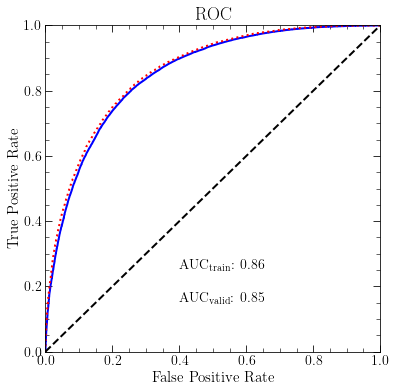

In [17]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(fpr_va, tpr_va, color='b', lw=2., label='validation')
ax.plot(fpr_tr, tpr_tr, color='r', ls=':', lw=2.,
        label='training')
ax.plot([0,1], [0,1], color='k', ls='--', lw=2.)
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
ax.set_title('ROC')
ax.text(0.4, 0.25, r"${\rm AUC_{train}}$: %.2f" %auc_tr)
ax.text(0.4, 0.15, r"${\rm AUC_{valid}}$: %.2f" %auc_va)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
print("AUC Training: %.4f" %auc_tr)
print("AUC Validation: %.4f" %auc_va)

The above algorithm performs well! Its **variance** might feel a bit suboptimal (the value of AUC) but the **bias** is almost non-existent (${\rm AUC_{train}}$ - ${\rm AUC_{valid}}$)  

***
## Infer feature importances
Using the `RandomForestClassifier` attribute `feature_importances_` 

In [18]:
performance = cls.feature_importances_    # returns feature importances in the order in which they were
                                          # provided to the classifier upon fitting 

Text(0, 0.5, 'Relative performance')

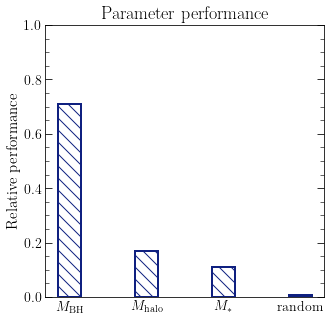

In [19]:
# plot the feature importances

varnames = np.array([
    'random', r'$M_{\rm BH}$', 
    r'$M_{\rm halo}$', r'$M_\ast$'
    ])
idx = np.argsort(performance)[::-1]  # sort the variables in order of decreasing performance

fig, ax = plt.subplots(figsize=(5,5))
loc = np.arange(features_tr.shape[1])
ax.bar(loc, performance[idx], width=0.3, 
       edgecolor='#0F2080', facecolor='w',
       hatch=2*'\\', lw=2)
ax.set_xticks(loc)
ax.tick_params(which='both', axis='x', bottom=False, top=False)
ax.set_ylim(0,1)
ax.set_xticklabels(varnames[idx])
ax.set_title('Parameter performance')
ax.set_ylabel('Relative performance')

***
# The dangers of overfitting

This time let us see what happens when we allow the algorithm for maximum flexibility 

### Maximum flexibility = the RF learns the training set very well but is not generalisable 

In [20]:
cls_flex = RandomForestClassifier(n_estimators=200,    
                                  min_samples_leaf=1,
                                  max_features=None,    # note that now the classifier can use all features 
                                  n_jobs=-1)            # to decide on a split on every node

In [21]:
cls_flex.fit(features_tr, target_tr)    

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [22]:
# class probabilities
prob_class_tr_flex = cls_flex.predict_proba(features_tr)[:,1]    
prob_class_va_flex = cls_flex.predict_proba(features_va)[:,1]

# ROC & AUC
fpr_tr_flex, tpr_tr_flex, thresholds_flex = roc_curve(target_tr, prob_class_tr_flex)    
auc_tr_flex = auc(fpr_tr_flex, tpr_tr_flex)                                       
fpr_va_flex, tpr_va_flex, thresholds_flex = roc_curve(target_va, prob_class_va_flex)    
auc_va_flex = auc(fpr_va_flex, tpr_va_flex)

AUC Training: 1.0000
AUC Validation: 0.8374


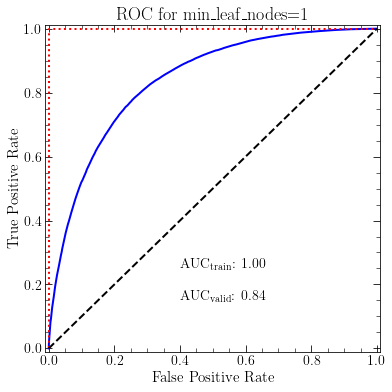

In [23]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(fpr_va_flex, tpr_va_flex, color='b', lw=2., label='validation')
ax.plot(fpr_tr_flex, tpr_tr_flex, color='r', ls=':', lw=2.,
        label='training')
ax.plot([0,1], [0,1], color='k', ls='--', lw=2.)
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
ax.set_title('ROC for min\_leaf\_nodes=1')
ax.text(0.4, 0.25, r"${\rm AUC_{train}}$: %.2f" %auc_tr_flex)
ax.text(0.4, 0.15, r"${\rm AUC_{valid}}$: %.2f" %auc_va_flex)
ax.set_xlim(-0.01, 1.01)
ax.set_ylim(-0.01, 1.01)
print("AUC Training: %.4f" %auc_tr_flex)
print("AUC Validation: %.4f" %auc_va_flex)

The RF trains on the training set to perfection, however it is extremely biased and hence **not generalisable**. We can no longer use our algorithm to predict unknown classes for entirely new objects

*** 
# Why not use a single decision tree?

In [24]:
from sklearn.tree import DecisionTreeClassifier

# Make a decision tree and train
tree = DecisionTreeClassifier(random_state=12)
tree.fit(features_tr, target_tr)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12, splitter='best')

In [25]:
# Make probability predictions
prob_class_tr_tree = tree.predict_proba(features_tr)[:, 1]
prob_class_va_tree = tree.predict_proba(features_va)[:, 1]

In [26]:
# ROC & AUC
fpr_tr_tree, tpr_tr_tree, thresholds_tree = roc_curve(target_tr, prob_class_tr_tree)    
auc_tr_tree = auc(fpr_tr_tree, tpr_tr_tree)                                       
fpr_va_tree, tpr_va_tree, thresholds_tree = roc_curve(target_va, prob_class_va_tree)    
auc_va_tree = auc(fpr_va_tree, tpr_va_tree)

AUC Training: 1.0000
AUC Validation: 0.6858


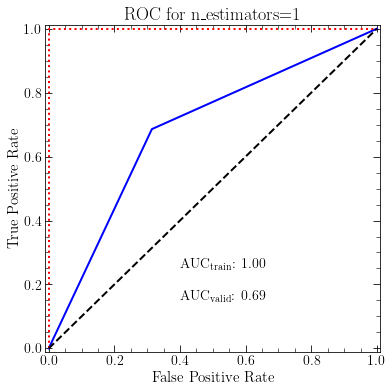

In [27]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(fpr_va_tree, tpr_va_tree, color='b', lw=2., label='validation')
ax.plot(fpr_tr_tree, tpr_tr_tree, color='r', ls=':', lw=2.,
        label='training')
ax.plot([0,1], [0,1], color='k', ls='--', lw=2.)
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
ax.set_title('ROC for n\_estimators=1')
ax.text(0.4, 0.25, r"${\rm AUC_{train}}$: %.2f" %auc_tr_tree)
ax.text(0.4, 0.15, r"${\rm AUC_{valid}}$: %.2f" %auc_va_tree)
ax.set_xlim(-0.01, 1.01)
ax.set_ylim(-0.01, 1.01)
print("AUC Training: %.4f" %auc_tr_tree)
print("AUC Validation: %.4f" %auc_va_tree)

We can see again that the tree learns its training set perfectly. However, when exposed to previously unseen data, it performs much worse than a combination of randomised trees with the same depth and leaf size priviliges
